In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation #necessite ffmpeg pour enregistrer les animations
% matplotlib inline

In [2]:
from scipy.fftpack import fft
def dsp(theta, sigma2, T, N = 512):
    dsp_array = np.matrix(np.zeros((N, T)))
    
    f = np.arange(N, dtype = 'double')/N
    
    d = theta.shape[0]
    
    for t in np.arange(T):
        dsp_array[:,t] = np.matrix(sigma2/(2*np.pi*abs(fft(theta[:,t].T, N)) ** 2)).T
        
       
    return f, dsp_array

## Introduction

Ce notebook vise à présenter l'évolution d'un TVAR(2) en fonction du choix de T qui définit l'intervalle entre deux mesures du processus sur l'intervalle [0,1].

Rappelons que nous définissons le TVAR(2) comme suit $\forall t$ dans $[0,T]$:

\begin{equation}
X_{t,T} = a_1(\frac{t}{T})X_{t-1,T} + a_2(\frac{t}{T})X_{t-2,T} + \sigma(\frac{t}{T})\epsilon_{t,T}
\end{equation}

Avec $\epsilon_{t,T}$ un bruit blanc centré de variance 1.
Dans la suite, pour simplifier les expressions, on prendra $\sigma(u)=1$ sur $[0,1]$.

Les processus seront construits à partir des racines du polynôme associé. On cherche à illustrer l'influence des racines sur la DSP

## Premier exemple : racines réelles

Prenons le polynôme caractéristique avec $\forall u$ dans $[0,1]$:
    \begin{equation}
    A(z;u) = 1 - a_1(u) z - a_2(u) z^2
    \end{equation}

Pour le cas $p=2$, il est facile de choisir des coefficients pour le TVAR puisqu'on a les relations coefficients/racines suivantes lorsque l'on note $z_1$ et $z_2$ les inverse des racines du polynome $1-a_1z - a_2z^2$:
\begin{equation}
a_1 = z_1 + z_2
\end{equation}
\begin{equation}
a_2 = -z_1 z_2
\end{equation}

Donc en choisissant les racines variant au cours du temps $u$ dans $[0,1]$ $z_1(u) = \frac{1}{2 + u}$ et $z_2(u) = \frac{1}{5 + \sin(2 \pi u)}$ (on vérifie bien la condition que $|z| < 1$), on a les coefficients : 

\begin{equation}
a_1(u) = \frac{7 + u+ \sin(2\pi u)}{(2 + u)(5 +\sin(2 \pi u))}
\end{equation}
\begin{equation}
a_2(u) = \frac{-1}{(2 + u)(5 + \sin(2 \pi u))}
\end{equation}

In [3]:
epsilon = np.random.randn(int(2e4))

### T = 100

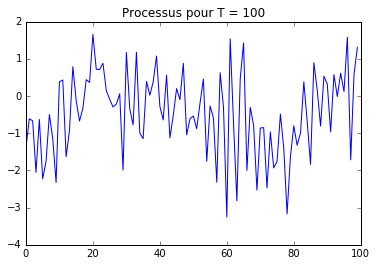

In [4]:
T = 100
X = np.zeros(2*T)
a_1 = np.zeros(2*T)
a_2 = np.zeros(2*T)

u = np.arange(T, dtype='double')/T

a_1[T:2*T] =  (7 + u + np.sin(2 * np.pi * u)) / ((2 + u) * (5 + np.sin(2 * np.pi * u)))
a_2[T:2*T] = - 1. / ((2 + u) * (5 + np.sin(2 * np.pi * u)))

    
X[0] = epsilon[0]
X[1] = epsilon[100]
    
for n in np.arange(2*T-2):
    X[n+2] = a_1[n+2]*X[n-1] + a_2[n+2]*X[n-2] + epsilon[(n+2)*100]
    
t = np.arange(2*T) - T #horizon des temps

plt.plot(t[T:2*T], X[T:2*T])
plt.title("Processus pour T = 100")

### T = 1000

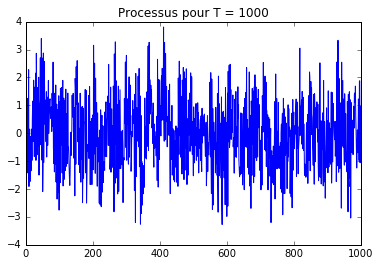

In [5]:
T = 1000
X = np.zeros(2*T)
a_1 = np.zeros(2*T)
a_2 = np.zeros(2*T)

u = np.arange(T, dtype='double')/T

a_1[T:2*T] =  (7 + u + np.sin(2 * np.pi * u)) / ((2 + u) * (5 + np.sin(2 * np.pi * u)))
a_2[T:2*T] = - 1. / ((2 + u) * (5 + np.sin(2 * np.pi * u)))
    
X[0] = epsilon[0]
X[1] = epsilon[10]
    
for n in np.arange(2*T-2):
    X[n+2] = a_1[n+2]*X[n-1] + a_2[n+2]*X[n-2] + epsilon[(n+2)*10]
    
t = np.arange(2*T) - T #horizon des temps

plt.plot(t[T:2*T], X[T:2*T])
plt.title("Processus pour T = 1000")

### T = 10000

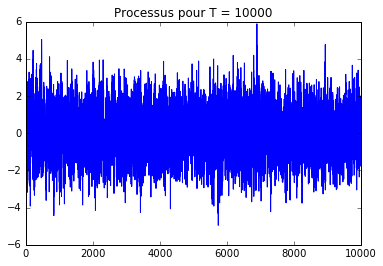

In [6]:
T = 10000
X = np.zeros(2*T)
a_1 = np.zeros(2*T)
a_2 = np.zeros(2*T)

u = np.arange(T, dtype='double')/T

a_1[T:2*T] =  (7 + u + np.sin(2 * np.pi * u)) / ((2 + u) * (5 + np.sin(2 * np.pi * u)))
a_2[T:2*T] = - 1. / ((2 + u) * (5 + np.sin(2 * np.pi * u)))
    
X[0] = epsilon[0]
X[1] = epsilon[1]
    
for n in np.arange(2*T-2):
    X[n+2] = a_1[n+2]*X[n-1] + a_2[n+2]*X[n-2] + epsilon[n+2]
    
t = np.arange(2*T) - T #horizon des temps

plt.plot(t[T:2*T], X[T:2*T])
plt.title("Processus pour T = 10000")

## Deuxième exemple : racines complexes conjuguées 

On s'intéresse maintenant au cas où les racines que l'on recherche sont complexes conjuguées.

Si on note $r = r_1 + ir_2$ l'inverse de l'une des deux racines, on a par les relations coefficients/racines que:
\begin{equation}
a_1 = 2Re(r)
\end{equation}
\begin{equation}
a_2 = -|r|^2
\end{equation}

### Premier cas : module constant, phase variable

On prend :
$$
r(u) = \rho e^{i\phi(u)}, \, 0 < \rho < 1, \phi(u) \in [-\pi,\pi[
$$
ce qui donne :
$$
a_1 = 2 \cos(\phi(u))
$$
$$
a_2 = - \rho^2
$$

#### Construction pour T=1000

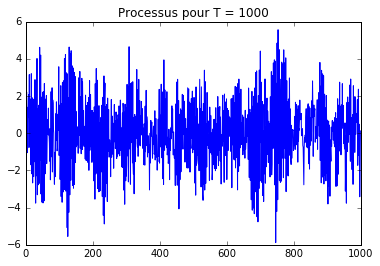

In [7]:
T = 1000
X = np.zeros(2*T)
a_1 = np.zeros(2*T)
a_2 = np.zeros(2*T)

u = np.arange(T, dtype='double')/T

rho = 0.6
phase = 0.2
phi = 2*np.pi*phase

a_1[T:2*T] = 2*np.cos(phi)
a_2[T:2*T] = -rho**2


X[0] = epsilon[0]
X[1] = epsilon[1]
    
for n in np.arange(2*T-2):
    X[n+2] = a_1[n+2]*X[n-1] + a_2[n+2]*X[n-2] + epsilon[n+2]
    
t = np.arange(2*T) - T #horizon des temps

plt.plot(t[T:2*T], X[T:2*T])
plt.title("Processus pour T = 1000")

#### Analyse spectrale

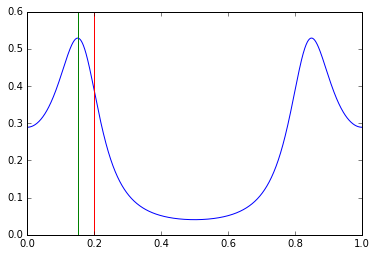

In [8]:
# Analyse spectrale
Nfft = 2**10
sigma2 = 1.
Theta = np.concatenate((np.ones((1,T)),-a_1[T:2*T].reshape(1,T),-a_2[T:2*T].reshape(1,T)),axis=0)
freq, dsp_array = dsp(Theta,sigma2,T,Nfft)

freq = freq.reshape(Nfft,1)

#for t in np.arange(T):
#    dsp_array[:,t] = sigma2 / (2*np.pi*np.abs((1-1./rho*np.exp(-2*1j*np.pi*(freq+phase)))
#                                              *(1-1./rho*np.exp(-2*1j*np.pi*(freq-phase))))**2)


#plt.plot(freq,np.abs(1-1./rho*np.exp(-2*1j*np.pi*(freq-phase)))**2)
#plt.plot(freq,np.abs(1-1./rho*np.exp(-2*1j*np.pi*(freq+phase)))**2)
#plt.plot(freq,np.abs(1-1./rho*np.exp(-2*1j*np.pi*(freq+phase)))**2 * np.abs(1-1./rho*np.exp(-2*1j*np.pi*(freq-phase)))**2)

plt.figure()
plt.plot(freq, dsp_array[:,21])

for t in np.linspace(21,21,1):
    plt.axvline(x=phase, ymin=0, ymax=1, linewidth=1, color = 'r')
    plt.axvline(x=freq[np.argmax(dsp_array[0:Nfft/2,t])], ymin=0, ymax=1, linewidth=1, color = 'g')

    
plt.show()

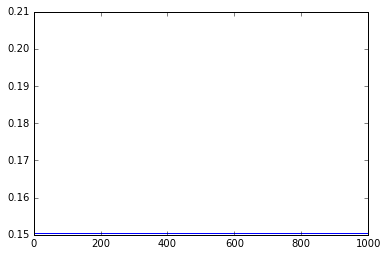

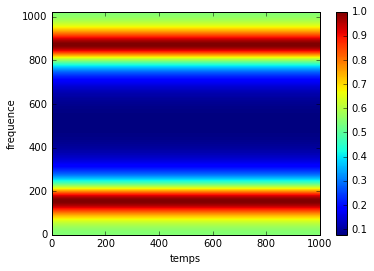

In [9]:
max_pos = np.zeros(T)
for t in np.arange(T):
    dsp_array[:,t] = dsp_array[:,t] / np.max(dsp_array[:,t])
    max_pos[t] = np.argmax(dsp_array[0:Nfft/2,t])

    
plt.figure()
plt.plot(max_pos / Nfft)
plt.plot(phase)
    
plt.figure()
plt.imshow(np.transpose(dsp_array.T),origin="lower", aspect="auto")
plt.colorbar()

plt.xlabel("temps")
plt.ylabel("frequence")


# Exemple du TVAR(1)
Le polynôme est $1 - a(u)z$. 
$a(u)$ étant l'inverse de la racine. On prend $a(u)=\rho(u) e^{i\phi(u)}$

## Cas où $\phi$ est constant

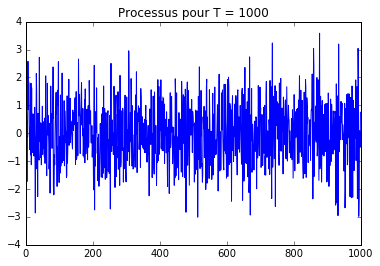

In [10]:
T = 1000
X = np.zeros(2*T, dtype='complex')
a = np.zeros(2*T, dtype='complex')

u = np.arange(T, dtype='double')/T

rho = 1-np.exp(-u)
phase = 0.5
phi = 2.*np.pi*phase

a[T:2*T] = rho*np.exp(1j*phi)

X[0] = epsilon[0]
    
for n in np.arange(2*T-1):
    X[n+1] = a[n+1]*X[n-1] + epsilon[n+2]
    
t = np.arange(2*T) - T #horizon des temps

plt.plot(t[T:2*T], np.real(X[T:2*T]))
plt.title("Processus pour T = 1000")

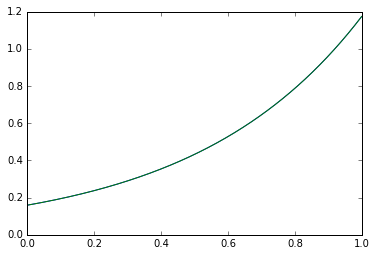

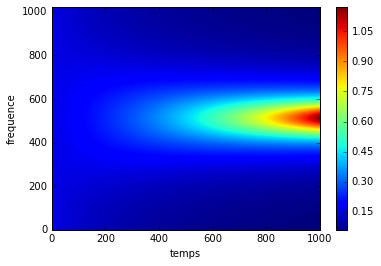

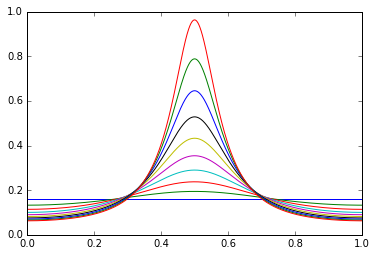

In [11]:
# Analyse spectrale
Nfft = 2**10
sigma2 = 1.
Theta = np.concatenate((np.ones((1,T),dtype='complex'),-a[T:2*T].reshape(1,T)),axis=0)
freq, dsp_array = dsp(Theta,sigma2,T,Nfft)

freq = freq.reshape(Nfft,1)

max_val = np.zeros(T)
for t in np.arange(T):
    max_val[t] = np.max(dsp_array[:,t])

    
plt.figure()
plt.plot(u, max_val)
plt.plot(u, sigma2/(2*np.pi*(1-rho)**2))
#plt.ylim(0,1)

plt.figure()
plt.imshow(dsp_array,origin="lower", aspect="auto")
plt.colorbar()

plt.xlabel("temps")
plt.ylabel("frequence")

plt.figure()
plt.plot(freq, dsp_array[:,0::100])

plt.show()

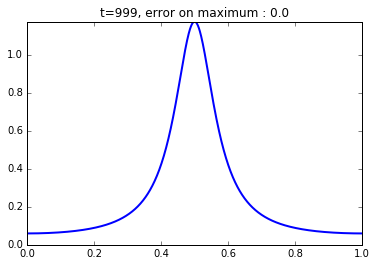

In [12]:
### Animation 
# Definition de la figure et des axes
fig = plt.figure()
ax = plt.axes(xlim=(0,1), ylim = (0,np.max(dsp_array)))
line, = ax.plot([], [], lw=2)
max_theo, = ax.plot([],[],'r--',lw=1) 
maximum, = ax.plot([],[],'g--',lw=1) 


# Fonction d'initialisation : affiche le fond à chaque étape
def init():
    line.set_data([], [])
    max_theo.set_data([],[])
    maximum.set_data([],[])
    return line, max_theo, maximum

# Fonction d'animation
def animate(t):
    line.set_data(freq, dsp_array[:,t])
    max_theo_val = sigma2/(2*np.pi*(1-rho[t])**2)
    max_theo.set_data([0,1],[max_theo_val,max_theo_val])  
    maximum.set_data([0,1],[max_val[t],max_val[t]])    
    ax.set_title("t=%d, error on maximum : %s"%(t, abs(max_theo_val - max_val[t])))
    return line, max_theo, maximum

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=T, interval=10, blit=True)

anim.save('TVAR1_racine_module.mp4',fps=30,extra_args=['-vcodec', 'libx264'])

## Cas où $\rho$ est constante

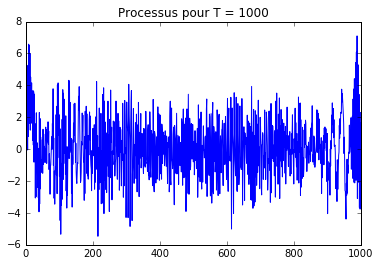

In [13]:
T = 1000
X = np.zeros(2*T, dtype='complex')
a = np.zeros(2*T, dtype='complex')

u = np.arange(T, dtype='double')/T

rho = 0.9
phase = u
phi = 2.*np.pi*phase

a[T:2*T] = rho*np.exp(1j*phi)

X[0] = epsilon[0]
    
for n in np.arange(2*T-1):
    X[n+1] = a[n+1]*X[n-1] + epsilon[n+2]
    
t = np.arange(2*T) - T #horizon des temps

plt.plot(t[T:2*T], np.real(X[T:2*T]))
plt.title("Processus pour T = 1000")

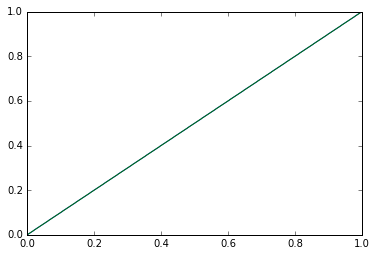

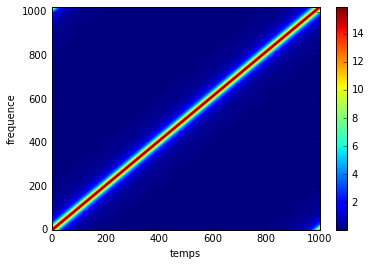

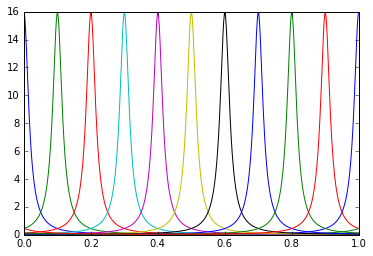

In [14]:
# Analyse spectrale
Nfft = 2**10
sigma2 = 1.
Theta = np.concatenate((np.ones((1,T),dtype='complex'),-a[T:2*T].reshape(1,T)),axis=0)
freq, dsp_array = dsp(Theta,sigma2,T,Nfft)

freq = freq.reshape(Nfft,1)

max_pos = np.zeros(T)
for t in np.arange(T):
    max_pos[t] = freq[np.argmax(dsp_array[:,t])]

    
plt.figure()
plt.plot(u, max_pos)
plt.plot(u, phase)
plt.ylim(0,1)

plt.figure()
plt.imshow(dsp_array,origin="lower", aspect="auto")
plt.colorbar()

plt.xlabel("temps")
plt.ylabel("frequence")

plt.figure()
plt.plot(freq, dsp_array[:,0::100])

plt.show()

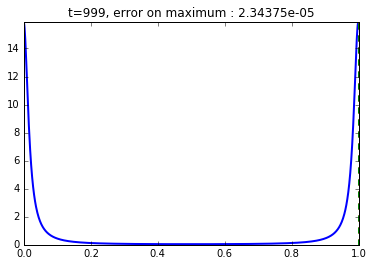

In [15]:
### Animation 
# Definition de la figure et des axes
fig = plt.figure()
ax = plt.axes(xlim=(0,1), ylim = (0,np.max(dsp_array)))
line, = ax.plot([], [], lw=2)
max_theo, = ax.plot([],[],'r--',lw=1) 
maximum, = ax.plot([],[],'g--',lw=1) 


# Fonction d'initialisation : affiche le fond à chaque étape
def init():
    line.set_data([], [])
    max_theo.set_data([],[])
    maximum.set_data([],[])
    return line, max_theo, maximum

# Fonction d'animation
def animate(t):
    line.set_data(freq, dsp_array[:,t])
    max_theo.set_data([phase[t],phase[t]],[0, np.max(dsp_array[:,t])])  
    maximum.set_data([max_pos[t],max_pos[t]],[0,np.max(dsp_array[:,t])])    
    ax.set_title("t=%d, error on maximum : %s"%(t, abs(phase[t] - max_pos[t])))
    return line, max_theo, maximum

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=T, interval=10, blit=True)

anim.save('TVAR1_racine_phase.mp4',fps=30,extra_args=['-vcodec', 'libx264'])